# Preface: The most INSANE language composability showcase you will ever see 😮 😱 😲

This workshop goes through Julia's core programming paradigm, **multiple dispatch**. It is arguably the reason Julia is able to overcome many difficulties plaguing other programming environments, and it is a prime reason of why Julia is a programming language most suitable for science.

Let's activate the directory of the Julia Zero2Hero workshop as we will be using some external packages for this showcase.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop`

Status `C:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\Project.toml`
  [1520ce14] AbstractTrees v0.4.4
  [6e4b80f9] BenchmarkTools v1.3.2
  [a134a8b2] BlackBoxOptim v0.6.2
  [13f3f980] CairoMakie v0.11.1
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.103
  [634d3b9d] DrWatson v2.13.0
  [fa6b7ba4] DualNumbers v0.6.8
  [61744808] DynamicalSystems v3.2.3
  [0987c9cc] MonteCarloMeasurements v1.1.6
⌃ [1dea7af3] OrdinaryDiffEq v6.59.2
  [1a8c2f83] Query v1.0.0
  [1e83bf80] StaticArraysCore v1.4.2
  [0c5d862f] Symbolics v5.10.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


Consider the expression $f(x, y) = \sin(xy)^2$, but in a context agnostic to what $x, y$ is. A Julia function for this is

In [2]:
f(x, y) = sin(x*y)^2

f (generic function with 1 method)

In Julia, this function can be called with anything that supports the mathematical abstraction the function alludes to. For example:

In [3]:
f(1.0, π) # reals

1.4997597826618576e-32

In [4]:
f(rand(4,2), rand(2,4)) # matrices (sine of a matrix is well defined)

4×4 Matrix{Float64}:
 0.54576    0.115557   0.226242   0.413807
 0.0995321  0.0210348  0.041297   0.0754142
 0.392643   0.0648581  0.179566   0.273217
 0.281859   0.0835823  0.0948759  0.245742

In [5]:
using DualNumbers # numbers that carry a function derivative along them; used in automatic differentiation
x = Dual(0.1, 0.5)
y = Dual(0.2, 0)
f(x, y) # returns a dual number (has numeric derivative)

0.00039994666951103004 + 0.003998933418663417ɛ

In [6]:
using MonteCarloMeasurements # numbers that actually represent a probability distribution
using Distributions          # package offering probability distributions
x = π ± 0.5 # normally distributed variable
y = Particles(2000, Gumbel(π-0.5, 0.5)) # a different distribution
z = f(x, y) # returns a probability distribution (monte carlo sampled particles)

0.502216 ± 0.356 Particles{Float64, 2000}


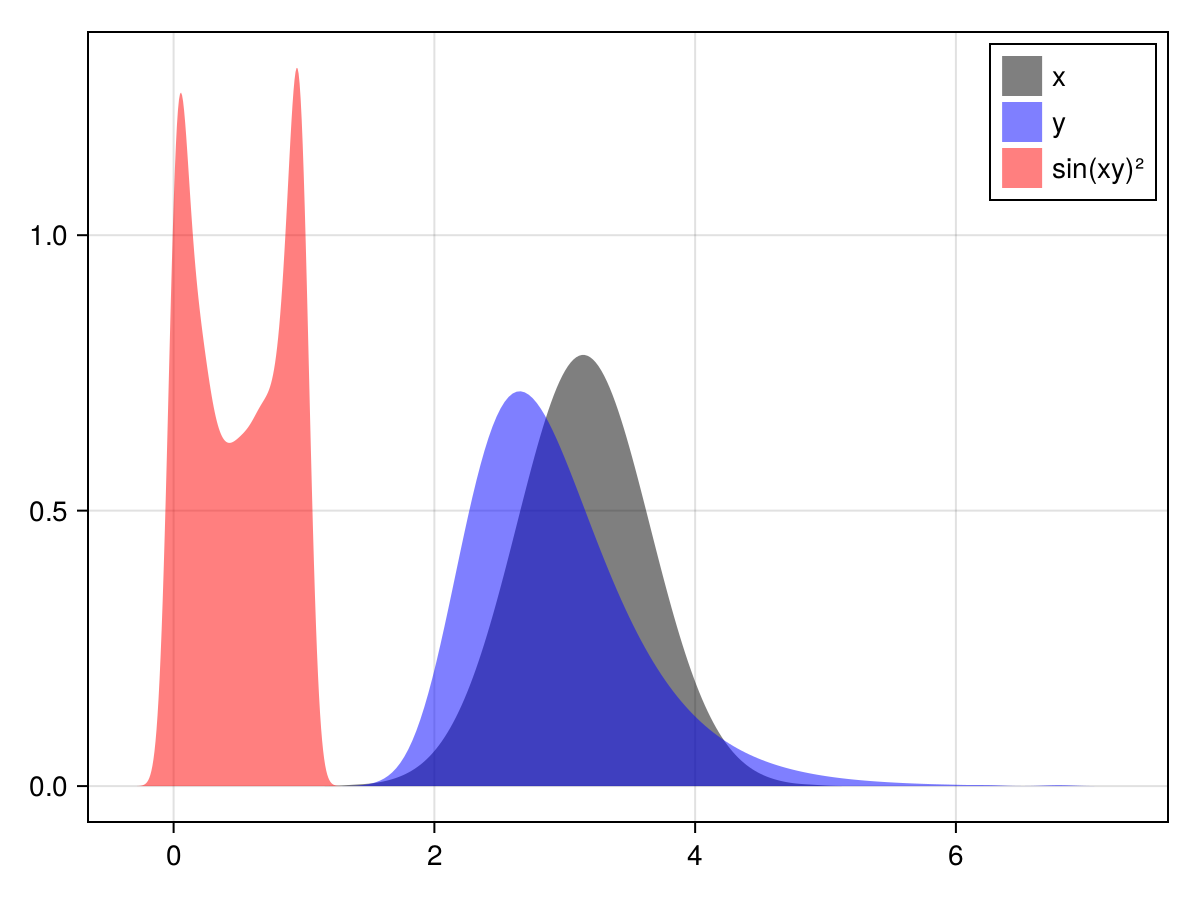

In [7]:
# visualize it to make it clear that we are *effectively* performing
# operations on probability distributions
using CairoMakie
fig, ax = density(x.particles; color = ("black", 0.5), label = "x")
density!(y.particles; color = ("blue", 0.5), label = "y")
density!(z.particles; color = ("red", 0.5), label = "sin(xy)²")
axislegend()
fig

In [8]:
using Symbolics # next-gen symbolic math library
@variables x y # symbolic variables instead of real numbers
expression = f(x, y) # returns a symbolic expression
expand_derivatives(Differential(x)(expression)) # that can be used in symbolic algebra

2y*cos(x*y)*sin(x*y)

_Huh, seems cool, but why does it matter...?_

Well, think that you were using the `sin` function inside, well, let's say, a differential equation code. For example to solve the differential equation of the simple pendulum (in normalized units)
$$
\begin{align}
\theta ' &= \omega \\
\omega ' &= - \sin(\theta)
\end{align}
$$
we would write the simple code (unoptimized simplified example)

In [9]:
using OrdinaryDiffEq # for solving ODEs
pendulum(u, p, t) = [u[2], -sin(u[1])] # return the derivative given state, parameters, time
u0 = [0, π/3] # initial condition for solving the ODE
tspan = (0.0, 20.0) # timespan to solve in
prob = ODEProblem(pendulum, u0, tspan)
sol = solve(prob, Euler(); dt = 0.01)

retcode: Success
Interpolation: 3rd order Hermite
t: 2001-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.060000000000000005
  0.07
  0.08
  0.09
  ⋮
 19.920000000000314
 19.930000000000316
 19.940000000000317
 19.95000000000032
 19.96000000000032
 19.970000000000322
 19.980000000000324
 19.990000000000325
 20.0
u: 2001-element Vector{Vector{Float64}}:
 [0.0, 1.0471975511965976]
 [0.010471975511965976, 1.0471975511965976]
 [0.020943951023931952, 1.0470928333554352]
 [0.031414879357486304, 1.0468834091566017]
 [0.04188371344905232, 1.0465693120324375]
 [0.05234940656937669, 1.046150597344396]
 [0.06281091254282066, 1.0456273423483986]
 [0.07326718596630465, 1.0449996461453193]
 [0.08371718242775784, 1.0442676296166633]
 [0.09415985872392447, 1.043431435345513]
 ⋮
 [-0.6752209213516657, 0.9208694250633547]
 [-0.6660122271010321, 0.9271201228264722]
 [-0.6567410258727674, 0.9332986763761494]
 [-0.6474080391090059, 0.9394040667397529]
 [-0.6380139984416083, 0.94543527

What would happen if for the initial state we used a dual number (which would enable automatic differentiation to run through our differential equation solving)?

In [10]:
u0_dual = [Dual(0.0, 0.0), Dual(π/3, 0.2)]
prob_dual = ODEProblem(pendulum, u0_dual, tspan)
sol_dual = solve(prob_dual, Euler(); dt = 0.01)
sol_dual.u # vector with the solution

2001-element Vector{Vector{Dual128}}:
 [0.0 + 0.0ɛ, 1.0471975511965976 + 0.2ɛ]
 [0.010471975511965976 + 0.002ɛ, 1.0471975511965976 + 0.2ɛ]
 [0.020943951023931952 + 0.004ɛ, 1.0470928333554352 + 0.1999800010966127ɛ]
 [0.031414879357486304 + 0.005999800010966127ɛ, 1.0468834091566017 + 0.1999400098692737ɛ]
 [0.04188371344905232 + 0.007999200109658863ɛ, 1.0465693120324375 + 0.19988004147258182ɛ]
 [0.05234940656937669 + 0.009998000524384681ɛ, 1.046150597344396 + 0.199800119624031ɛ]
 [0.06281091254282065 + 0.011996001720624991ɛ, 1.0456273423483986 + 0.19970027658312506ɛ]
 [0.07326718596630463 + 0.013993004486456241ɛ, 1.0449996461453193 + 0.1995805531219053ɛ]
 [0.08371718242775783 + 0.015988810017675294ɛ, 1.0442676296166633 + 0.19944099848693514ɛ]
 [0.09415985872392446 + 0.017983220002544646ɛ, 1.043431435345513 + 0.19928167035279915ɛ]
 ⋮
 [-0.6752209213516684 - 0.8503582725709029ɛ, 0.9208694250633537 - 0.32113545402133725ɛ]
 [-0.6660122271010349 - 0.8535696271111163ɛ, 0.9271201228264712 - 0.31

What would happen if for the initial state we used an uncertain value distribution?

In [11]:
u0_uncertain = [0 ± 0.1, π/3 ± 0.2]
prob_uncertain = ODEProblem(pendulum, u0_uncertain, tspan)
sol_uncertain = solve(prob_uncertain, Euler(); dt = 0.01)
sol_uncertain.u # vector with the solution

2001-element Vector{Vector{Particles{Float64, 2000}}}:
 [2.57e-19 ± 0.1, 1.05 ± 0.2]
 [0.0105 ± 0.1, 1.05 ± 0.2]
 [0.0209 ± 0.1, 1.05 ± 0.2]
 [0.0314 ± 0.1, 1.05 ± 0.2]
 [0.0419 ± 0.1, 1.05 ± 0.2]
 [0.0523 ± 0.1, 1.05 ± 0.2]
 [0.0628 ± 0.1, 1.05 ± 0.2]
 [0.0733 ± 0.1, 1.05 ± 0.2]
 [0.0837 ± 0.1, 1.04 ± 0.2]
 [0.0942 ± 0.1, 1.04 ± 0.2]
 ⋮
 [-0.658 ± 0.6, 0.607 ± 0.52]
 [-0.652 ± 0.6, 0.613 ± 0.52]
 [-0.646 ± 0.61, 0.618 ± 0.52]
 [-0.64 ± 0.61, 0.623 ± 0.52]
 [-0.634 ± 0.61, 0.628 ± 0.52]
 [-0.628 ± 0.61, 0.633 ± 0.52]
 [-0.621 ± 0.62, 0.637 ± 0.51]
 [-0.615 ± 0.62, 0.642 ± 0.51]
 [-0.608 ± 0.62, 0.647 ± 0.51]

**_It just works._**

Notice that I am not cheating here: there is **no glue code** between `OrdinaryDiffeq, DualNumbers, MonteCarloMeasurements`. These three packages are completely ignorant about each other! The language enables this interaction natively. In fact, this exact system is the basis for implementing neural ODEs in Julia, where part of the equations are Neural Networks!

This incredible amount of power could not occur in e.g., Python, because it doesn't have one `sin` function. There is `pytorch.sin, numpy.sin, sympy.sin`. You would have to re-write your code three times for machine learning (autodiff), standard ODE solving, symbolic numerics, etc.

Let's see how Julia makes all of this possible!

# Types

As eluded to in the previous lecture, all values in Julia have a specific Type. The Type system (i.e. the hierarchy of "data identities" anything in Julia has) is the the basis of multiple dispatch (next section). 
Julia's type system is dynamic but also allows to indicate that certain values are of specific type (i.e. static typing).

**Quick important notice: "Types" are written in CamelCase by convention: `String`, `AbstractVector`, `Float64` while "values" and "functions" use lowercase `string`, `vector`, `float`.**

## Type tree

All values in Julia have a type that belongs to a single, fully connected type tree, all nodes of which are equally first-class as types. There is no distinction between native Julia types and user-created ones.

The "central" node of this tree is `Any`, which literally means any possible value. The functions `subtypes` and `supertype` show the children or the parent of a node in this tree.

In [12]:
subtypes(Float64) # this does not have subtypes, it is a "leaf" of the Type tree

Type[]

In [13]:
supertype(Float64)

AbstractFloat

Notice that `subtypes/supertype` must take a Type as an input, not a value! E.g. `subtypes(5.0)` fails, as `5.0` is not a type, but it is instead an *instance* of the type `Float64`.

In [14]:
supertype(AbstractFloat)

Real

In [15]:
supertype(Real)

Number

In [16]:
supertype(Number)

Any

We've reached the "central" node of the Type tree.

You can also use the operator `<:` to check if something is a "subtype of" something else, for example

In [19]:
Float64 <: Number

true

In [20]:
Float64 <: Int

false

## Abstract and concrete types

Concrete types are anything that can be actually instantiated. Any value that exists in Julia code that is running always has a concrete type. On the other hand, abstract types exist only to establish hierarchical relations between the concrete types. At the moment we don't have a reason for hierarchical relations, but once we talk about Multiple Dispatch this reason will become apparent.

In terms of mathematical reasoning, the distinction between abstract and concrete is simple: concrete types are leaves of the Type tree, while abstract types are anything else.

Based on the above tree of the `Number` type, one can see that `Number, Real, AbstractFloat` are all abstract types, while `Float64, Float32` are concrete. 

## Custom types

It is of course possible to create your own Types. This happens with the `struct` and `mutable struct` keywords like so

In [21]:
struct A
    x
    y
end

mutable struct B
    x
    y
end

Types are instantiated by calling them as if they are functions, with arguments their fields (this is the "default" constructor, and one can make any arbitrary constructor they want).

In [22]:
a = A(1, 2)

A(1, 2)

In [23]:
b = B(2,3)

B(2, 3)

Here the *values* `a, b` are *instances* of the *Types* `A, B`. The difference between the two is that the `mutable` keyword establishes that any instance of type `B` can be mutated in place. This is not possible for `A`, and the only way to change its values is to make a new instance of `A` alltogether.

Accessing the *fields* of the a Type is done by `a.fieldname`

In [24]:
(a.x, b.x)

(1, 2)

In [25]:
b.x = 5 # possible because b (of type B) is mutable

5

In [26]:
a.x = 5 # impossible

ErrorException: setfield!: immutable struct of type A cannot be changed

Notice that the way we defined `A, B` here is **bad for performance**. The fields `x, y` can have any possible Type, as we added no restrictions to them. This means that once a function gets an instance of `A`, the compiler cannot optimize this function, as it is impossible to know by the type `A` what are the actual data structures involved. This is another form of Type instability that we discussed in the first session!

To avoid this, use the type assertion operator `::` to enforce a Type to the fields of a `struct` definition.

In [27]:
struct Agood
    x::Float64
    y::Float64
    z::String
end

In [28]:
julia = Agood(1, 1, "best language evaaaah")

Agood(1.0, 1.0, "best language evaaaah")

This is means that `Agood` is **concretely typed**. (super-duper important by the way)

### Abstract types

As we specified no subtyping rule for `A, B`, they are by definition subtypes of the central node of the tree, `Any`. Abstract types are meaningful for subtyping relations.

Abstract types are defined with the `abstract type` keyword

In [29]:
abstract type C end

At the moment `C` is a subtype of `Any`. It is an abstract type so it is impossible to instantiate:

In [30]:
C(4)

MethodError: MethodError: no constructors have been defined for C

To make `C` useful, we can create some subtypes of `C` using the subtyping operator `<:`

In [31]:
struct D <: C
    d::Number
end

Now `D` is a subtype of `C`:

In [32]:
subtypes(C)

1-element Vector{Any}:
 D

Just to be clear, the above definition of `D` is **also type-unstable**. Sure, it is better to specific that the field of `D` is some subtype of `Number`, but `Number` is still an abstract type!

## Parametric types

Julia types can be parameterized based on other types, meaning that you can indeed make a field of a type to be "anything that is a number", and still be type stable!

This is very useful for reducing code replication as well as leveraging multiple dispatch more. Type-parameterization means that when defining a `struct`, the fields of the struct could be of an arbitrary Type. Type-parameterization uses the curly brackets syntax. For example:

In [33]:
struct Alpha{T}
    a::T
    b::T
end

Here the type `Alpha` can be instantiated using the low level constructor `Alpha{Type}(val1, val2)`, which will convert automatically `val1, val2` to `Type`. For example

In [34]:
a = Alpha{Int64}(1,1)

Alpha{Int64}(1, 1)

The high level constructor `Alpha(val1, val2)` also exists, and will try to deduce what `Type` should be based on the arguments:

In [35]:
Alpha(5, 6)

Alpha{Int64}(5, 6)

In [36]:
Alpha("test", 0.5)

MethodError: MethodError: no method matching Alpha(::String, ::Float64)

Closest candidates are:
  Alpha(::T, !Matched::T) where T
   @ Main c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:2


Since it is impossible to equivalently convert a string and a float to each other (as `1.0 != "1"`), one cannot instantiate `A` like this.

Here is a second example with two type-parameters:

In [37]:
struct TwoPars{T, F}
    a::T
    b::F
end

In [38]:
TwoPars("string", 0.5)

TwoPars{String, Float64}("string", 0.5)

And a final example:

In [39]:
struct ManyPars{T <: Real, F <: Union{String, Real}}
    a::T
    b::F
    c::Int
end

Here, to instantiate `ManyPars`, `a` must be a subtype of reals, `b` could be a string or a real, while `c` has to be an integer.

# Multiple dispatch
Multiple dispatch is the core programming paradigm of Julia. This notebook presents simple examples that can teach you multiple dispatch. 

## What is Multiple Dispatch?

Some handy definitions
* **function**: the name of the "function / process" we are referring to.
* **method**: what actually happens when we call the function with a specific combination of input arguments.

*Dispatch* means that when a function call occurs, the language decides somehow which of the function *methods* have to be used. 

### No dispatch
In no dispatch, as in e.g. C, there is nothing to be decided. The method and the function are one and the same. 

### Single dispatch
In single dispatch, as in most object-oriented languages (like Python), it is possible for the same function name to have different methods:
```
array.set_size(args...)
axis.set_size(args...)
```
where `array` could be an instance of something from `numpy` while `axis` could come from `matplotlib`. Here the language dispatches the function `set_size`, depending on the first argument, which is `array` or `axis`. It is important to note that in most object oriented languages, the **method is a property of the type**. 

### Multiple dispatch
Here dispatch occurs based on the type of **every single function argument**, as in
```
set_size(a::Array, args...) = ...
set_size(a::Axis, args...) = ...
set_size(s, a::Array, args...) = ...
set_size(a::Array, b::Vector) = ...
set_size(a::Array, x::Real, y::Real, z::Real) = ...
```
etc. This means that multiple dispatch allows for more exponentially more "expressive power", as one can use all arguments of the function to dispatch on.

### How it works

Multiple dispatch follows easy-to-understand rules based on the Julia type system hierarchy. 

Upon calling a function, Julia will try to find the method that is most specific across all arguments. This means that if a method is defined for both the abstract type combination, as well as the concrete type combination, Julia will always call the more concrete one. This rule also applies to e.g. parametric types, since `Vector{Float64}` is more specialized than `Vector`. This rule also applies to unions, since `Float64` is more specialized than `Union{Float64, String}`.

Two important points:

1. **methods do not belong to the Types!**
2. **new methods can be defined *after* the Types have been defined!**

## A simple example

#### Defining some types

In [40]:
abstract type Animal end # this is an abstract type. a supertype of the below

struct Dog <: Animal   # this is a concrete type. a subtype of the above
    name::String
end

struct Cat <: Animal
    name::String
end

Now let's instantiate four animals

In [41]:
fido = Dog("Fido")
rex = Dog("Rex")
whiskers = Cat("Whiskers")
spotty = Cat("Spotty")

Cat("Spotty")

And finally, let's define some functions that take advantage of these `Animal` types, as well as multiple dispatch. Adding a method to a function is done by simply defining the function while also declaring the Types you add a method for:

In [42]:
function encounter(a::Animal, b::Animal)
    verb = meets(a, b)
    println("$(a.name) meets $(b.name) and $verb")
end

meets(a::Animal, b::Animal) = "passes by"

meets (generic function with 1 method)

Both of the above functions are defined on the abstract type level.

In [43]:
encounter(fido, rex)
encounter(fido, spotty)

Fido meets Rex and passes by
Fido meets Spotty and passes by


We now define more specific methods like so:

In [44]:
meets(a::Dog, b::Dog) = "sniffs"
meets(a::Dog, b::Cat) = "chases"
meets(a::Cat, b::Dog) = "hisses"
meets(a::Cat, b::Cat) = "slinks"

meets (generic function with 5 methods)

*(notice how the amount of methods of `meets` increased)*

In [45]:
encounter(fido, rex)
encounter(fido, whiskers)
encounter(whiskers, spotty)
encounter(spotty, rex)

Fido meets Rex and sniffs
Fido meets Whiskers and chases
Whiskers meets Spotty and slinks
Spotty meets Rex and hisses


## Simple extension of multiple dispatch
What if we get a third animal? Like a rabbit? It is easy to extend the system

In [46]:
struct Rabbit <: Animal
    name::String
end

meets(a::Dog, b::Rabbit) = "wiggles its tail"
meets(a::Rabbit, b::Cat) = "hides"

hops = Rabbit("Hops")

Rabbit("Hops")

In [47]:
encounter(rex, hops)
encounter(hops, whiskers)

Rex meets Hops and wiggles its tail
Hops meets Whiskers and hides


Of course, in the case where no specialized method exists, we get the default fallback we defined, as expected:

In [48]:
encounter(whiskers, hops)

Whiskers meets Hops and passes by


## Inspecting dispatch

To see how many methods a function has to it, and from which module they come, use `methods`:

In [49]:
methods(meets)

# 7 methods for generic function "meets" from Main:
 [1] meets(a::Dog, b::Dog)
     @ c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:1
 [2] meets(a::Dog, b::Cat)
     @ c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:2
 [3] meets(a::Cat, b::Dog)
     @ c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:3
 [4] meets(a::Cat, b::Cat)
     @ c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:4
 [5] meets(a::Dog, b::Rabbit)
     @ c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:5
 [6] meets(a::Rabbit, b::Cat)
     @ c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:6
 [7] meets(a::Animal, b::Animal)
     @ c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:6

To see which method is called on a function call signature, use `@which`:

In [50]:
@which meets(whiskers, rex)

meets(a::Cat, b::Dog)
     @ Main c:\Users\datse\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\2-MultipleDispatch.ipynb:3

*(notice that in VSCode `@which` allows you to go directly to the source code as well)*

In Julia, all "generic" functions are of equal "status". The function `+` is in no way superior, or with more privileges, than the function `meets` we wrote up.

It just has a bit more methods:

In [51]:
+

+ (generic function with 719 methods)

I won't be going into Modules and namespaces here. But it is important to note that it would be possible for us to extend `Animal` as well as `meets` *even if* they were coming from a different Module (e.g. a different Julia package).

Extension is identical with creating a new method, but one specifies the parent module as well:

In [52]:
Base.:+(a::Animal, b::Animal) = println("$(a.name) and $(b.name) are animals")
Base.:+(a::Cat, b::Cat) = println("$(a.name) and $(b.name) cutie-cats, much cuter than doggos!")

In [53]:
rex + whiskers

Rex and Whiskers are animals


In [54]:
spotty + whiskers

Spotty and Whiskers cutie-cats, much cuter than doggos!


## Dispatch on parametric types


Multiple dispatch can also be used on parametric types. Recall the definition of `Alpha`:
```julia
struct Alpha{T}
    a::T
    b::T
end
```
For example if we define:

In [55]:
foo(a::Alpha) = "generic function"
foo(a::Alpha{<:Number}) = "specific to A with any number"
foo(a::Alpha{Float64}) = "specific to A with 64-bit floats"

foo (generic function with 3 methods)

then

In [56]:
foo(Alpha("here's","a test"))

"generic function"

In [57]:
foo(Alpha(5, 6))

"specific to A with any number"

In [58]:
foo(Alpha(0.5, 0.6))

"specific to A with 64-bit floats"

To learn more about the type system and multiple dispatch please read the official Julia documentation on [Types](https://pkg.julialang.org/docs/julia/THl1k/1.1.1/manual/types.html) and [Methods](https://pkg.julialang.org/docs/julia/THl1k/1.1.1/manual/methods.html). 

# Generic algorithms

How does one go about writing a generic algorithm through multiple dispatch? Well, it's simple really, just don't specify types unless you absolutely have to!

## Some linear algebra algorithm
Imagine the following simple algorithm, that performs some linear algebra computations involving inner products. `A` is supposed to be a matrix, while `vs` is supposed to be a vector of vectors, and the inner product `v ⋅ A ⋅ v` is performed for every vector.

In [59]:
using LinearAlgebra: dot

function inner_sum(A, vs)
    t = zero(eltype(A))
    for v in vs
        t += inner(v, A, v)
    end
    return t
end

inner(v, A, w) = dot(v, A*w)

inner (generic function with 1 method)

In [60]:
a = rand(3,3)
vs = [rand(3) for i in 1:5]
inner_sum(a, vs)

5.73145167494516

* The above code is **generic**: any `A, vs` that support the correct operations (here `*` and `dot`), will work fine.

* Because Julia compiles all code based on the exact input types, `inner_sum` is also **arbitrarily efficient**. Given standard Julia matrices and vectors it uses BLAS. Given statically-sized arrays it uses super-efficient unrolled operations.

## The "OneHot" vector

In various fields that use linear algebra, like machine learning, a special vector datastracture is used often, called a "OneHot" vector. This vector has a 1 in a single entry, and 0 in all other entries. Having a dedicated structure for this vector is super efficient, because you only need to store 2 numbers to store it in memory, irrespectively of how large it is!

Let's create this in Julia. To make our life easy, we will make this new Type a subtype of `AbstractVector`. This means that all functions that are defined on the abstract level for `AbstractVector` will work with our type as well (provided we implement all the necessary *methods*).

In [61]:
struct OneHotVector <: AbstractVector{Bool}
    len::Int
    ind::Int
end

I "know" (by reading the documentation on the interface of `Array`) that the necessary methods I need to extend to make `OneHotVector` truly behave like any arbitrary Julia `vector` is (a) a `size` method and (b) a `getindex` method:

In [62]:
# Extend size (so that it behaves like an array)
Base.size(v::OneHotVector) = (v.len, )

# Extend indexing (so that accessing a OneHotVector like v[5] works)
Base.getindex(v::OneHotVector, i::Integer) = i == v.ind

In [63]:
oh = OneHotVector(10, 3) # its already a "true" Julia vector!

10-element OneHotVector:
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0

Does our algorithm already work with such a vector?

In [64]:
vs = [OneHotVector(3, rand(1:3)) for _ in 1:5]

inner_sum(a, vs)

3.0021016748601594

crazy stuff.

## OneHot inner product

It is already great that the above algorithm works with the new `OneHotVector` type. The generic code that one writes with Julia is extensible with **minimal** effort.

*But*, it currently uses the generic fallback `inner(w, A, v) = dot(w, A*v)`. This is inefficient! Let's break this down:

1. `A*v` is a matrix-vector multiplication. It iterates every column of `A` and multiplies them by each entry of `v`.
2. If the vector `v` has 0s everywhere and a 1 somewhere, then this operation in fact means `A[:, v.ind]`. I.e. we select the `v.ind`-th column of the matrix `A`.
3. `dot(w, Av)` is also generic, it indexes into `w` and `Av` and does a pair-wise multiplication.
4. Given the structure of `OneHotVector` we know that `inner(w, A, v)` is in fact just `A[w.ind, v.ind]`!

Increasing the performance of our algorithm is **trivial**. Simply extend `inner` for `OneHotVector`. But first, some benchmarks...

Here's how the performance of the algorithm would be without taking advantage of the internal structure of `OneHotVector`, and using it as if it was an full vector of 0s and 1s:

In [65]:
using BenchmarkTools

L = 100
a = rand(L, L)
vs = [OneHotVector(L, rand(1:L)) for _ in 1:5]

# timing before performance extension
@btime inner_sum($a, $vs)

  6.340 μs (5 allocations: 4.38 KiB)


1.7655228445205857

We now add the crucial extension:

In [66]:
inner(w::OneHotVector, a, v::OneHotVector) = a[w.ind, v.ind]

inner (generic function with 2 methods)

and time again:

In [67]:
# timing after performance extension
@btime inner_sum($a, $vs)

  5.300 ns (0 allocations: 0 bytes)


1.7655228445205857

Well, isn't this crazy.

# Code re-use in Julia

There is an astonishing amount of code-reuse and cooperation among different packages of the Julia ecosystem, as we will see in the next lecture much more than any other science-used language has achieved so far (see [Stefan Karpinski's talk for more details on this](https://www.youtube.com/watch?v=kc9HwsxE1OY)).

Naively one would think it is because of the ease of writing generic algorithms. This is in part true, but the reason Julia is the only language that truly succeeds in having all packages play nicely with each other (without each package actively writing glue code) is that you can re-use types from other people!

In the following I'll compare the story of "extending some else's type" in Julia and in Python, and the difference will become apparent.

Let's take as example the type `RGB`, which represents a color, and is defined in the Julia package `ColorTypes`. It is a simple type that bundles a value for red, green and blue, as well as defines some basic operations for the `RGB` type. For this example we can assume that `RGB` is defined as
```julia
struct RGB
  r::Float64
  g::Float64
  b::Float64
end
```

## Extending this type in Julia

Now someone wants to **extend this existing type** `RGB`. For example, one might want to create a color vector space. 

How is this done in Julia? 
Simple! Extend the functionality of `RGB` by adding new methods that dispatch on `RGB`. 

For example, you could extend **existing functions**
```julia
module ExtensionsToRGB # creates a new module (new "package")
using RGB

Base.zero(::RGB) = RGB(0,0,0)
Base.rand(::RGB) = RGB(rand(), rand(), rand())

end
```
etc., or **define new functions**
```julia
module ExtensionsToRGB # creates a new module (new "package")
export dotc
using RGB

# dot product in color space: convert to grayscale and then normalize
dotc(x::RGB, y::RGB) = 0.2*x.r*y.r + 0.771*x.g*y.g + 0.029*x.b*y.b

end
```

All of this "just works (TM)" in Julia, even if the type `RGB` comes from a completely independent Julia package!


## Is this possible in OOP (Python)?
In OOP the methods of a "class", are **defined literally textually within the class**. Therefore, if you wanted to extend this `RGB` in Python you would have two options:

1. Edit the text file that defines the original class.
2. Inherit the original class.

### (1) Modifying the original class
There are problems here:
* You have to convince the author of the original package that your code is worthy to be included.
* If everyone convinces the author about their method, the original class becomes huge and the source code becomes an unreadable mess.
* The original developer has to maintain everyone else's whacka-doodle methods.
* You can't change your mind about your extensions without potentially breaking everyone that uses the class `RGB`.

### (2) Inheriting
There are problems here as well:
* If you inherit, you can't "inherit the name"; you have to create a new type `MyRGB` that inherits `RGB`.
* Your extension will **not** actually apply to `RGB`, only to `MyRGB`. Therefore, anyone that creates `RGB` cannot potentially benefit from your code.
* This complexity increases quite fast; someone else makes `YourRGB` object, and then a third person tries to inherit from both `MyRGB` and `YourRGB` and makes an `OurRGB`, etc... Quickly becomes a hellhole!

### Why Julia does better here
Julia's multiple dispatch has none of the problems of (1) and (2). In addition, everyone that does not load the module `ExtensionsToRGB` is completely unaffected by whatever whacka-doodle shady business is happening there. On the other side, with the simple one liner `using ExtensionsToRGB`, you immediately gain access to all the extensions that have been done in that package. **And these extensions are valid for the single Julia type `RGB`**. No `MyRGB` nonsense!

The reasons why this is so trivial in Julia is because:

1. You can define new types to which *existing operations* apply
2. You can define new operations which apply to *existing types*

To go deeper into the concepts discussion in this section, you should have a look at this [blog post by Frames Catherine White](https://white.ucc.asn.au/2020/02/09/whycompositionaljulia.html) or this [talk by Stefan Karpinski](https://www.youtube.com/watch?v=kc9HwsxE1OY).

# Multiple dispatch & scientific thought

Multiple dispatch makes developing scientific codebases extremely efficient (from the perspective of how much time a human has to spend), because it allows packages to access, utilize, modify, and extend other packages' code super easily as we have seen so far in this notebook. This partly explains the surge of powerful packages that exist in Julia despite the language recency.

But I argue, there is one more fundamental reason multiple dispatch leads to incredibly efficient scientific programming, and further explains the package surge. It's because the way one rationalizes about code in multiple dispatch, is similar to the way one connects processes, objects, and ideas, in science. That is:

**Multiple dispatch is the programming paradigm that most closely parallels scientific thought, because it detaches the processes (functions) from the objects (data types).**

## Example: space simulations

Imagine that you are working in space exploration. You have rockets, planets, asteroids. The process "collide" can occur between all three of these objects, yet fundamentally different in each case:

1. when a rocket collides with an asteroid, the rocket explodes
2. when an asteroid collides with a planet, the asteroid is disintegrated
3. when a rocket collides with a planet, the rocket (hopefully) lands on the planet successfully
4. when an asteroid collides with another asteroid they both disintegrate
5. ...

Implementing this scientific scenario in multiple dispatch directly parallels how we think about it. Reasoning about this in an object-oriented framework is difficult, because the process "collide" must belong to one of the three objects. Yet, scientifically, this doesn't make any sense.

# Exercises

## Type hierarchies

Create a function `person_info(p)` that takes in any type of a "person" and prints their name and potentially some extra information. For a normal person, only the name is printed. If the person is a student, it should print their name *and* grade. If it is a group leader, then print their name and their group name. If the input to `person_info` is something other than a "person", it should error.

Solve this exercise without using a single `if` statement; only multiple dispatch. These kind of problems seem to be "natural" to solve using `if` statements. However using multiple dispatch instead makes the code clearer, more easy to extend and (typically) more performant, because of how Julia compiles code.

*Hint: given the rules of the exercise, you do not actually need abstract types to solve it. However, it is in general good practice to use them.*

## Indexing of a range type
Create your own `Range` object, which is an efficient iterable container defined by a `(start, step, stop)`, which gives numeric values incremented by `step` starting from `start`, while *ensuring* that the result never exceeds `stop`. You only need to extend `Base.getindex(r::Range, i::Int)` for this exercise. 

Test your range by initializing a range like `r = Range(0, 0.5, 1)`, and checking of `r[1], r[2], r[3]` give you indeed `0.0, 0.5, 1.0` as they should.

This object can efficiently represent this range while storing only these 3 numbers, instead of all elements that theoretically belong to the range.

*Hints:*
1. As a first step, define your `Range` `struct`, preferably by making it a parametric type of 1 type-parameter (think about how many fields it should have).
2. Use the help functionality to learn about the function `getindex`. The Julia syntax `A[i]` is translated to `getindex(A, i)`. 
3. Implement indexing for your Range type via extending `getindex`. Index `1` giving `start`. Be sure it errors for incorrect indices (where the value given by the range would exceed `stop`).

## Iteration of a range type

Continuing from the previous exercise, now make your `Range` object iterable by extending `Base.iterate(r::Range, state = 1)` as well as `Base.length(r::Range)`. It will then be possible to do `collect(range)` or `for a in range ...` or `[cos(r) for r in range]`.

*Hints:*

The [Julia documentation on the iteration API](https://pkg.julialang.org/docs/julia/THl1k/1.1.1/manual/interfaces.html#man-interface-iteration-1) shows that the Julia code block
```julia
for i in iter   # or  "for i = iter"
    # body
end
```

is in fact internally translated into:
```julia
next = iterate(iter)
while next !== nothing
    (i, state) = next
    # body
    next = iterate(iter, state)
end
```

1. To solve this exercise you need to define `Base.iterate(r::Range, state = 1)` which returns either the current element and the next iteration state (typically `i+1`) or `nothing` if there are no elements remaining to be iterated.
2. Test `iterate` for your `Range` by using it in a `for` loop: `for r in myrange; @show r; end`.

* **Bonus point** Did you write generic code? Try to see if your `Range` works with the package `Unitful`. This package provides types that combines numbers with physical units (like Newtons). Load this package with `using Unitful`. Does iterating a `Range(1u"kg", 0.1u"kg", 10u"kg")` work as expected? Make the necessary adjustments so that it does.

## Advanced whackadoodle iterator

Leveraging the experience of previous exercises, define an iterator object (and of course define `iterate` for it!) that has the following properties (**make an iterator struct, don't create a vector!**):

* It iterates for `n` elements. The first element is always `rand()`.
* At the odd steps of the iteration it returns the previous element divided by `rand()`.
* At the even steps of the iteration it returns the previous element multiplied by `rand()`.

Use this iterator object to efficiently study how its mean value behaves versus `n`, by using the function `mean` (accessible after `using Statistics`). 

*Hint: if you implement this iterator correctly, then you should be able to give it directly to `mean`.*

## Rational numbers

Implement the type `RationalNumber <: Real`, similar to Julia's `Rational`, but without being a parametric type (i.e. both fields are just `Int`). Using the following function
```julia
function simplify(n::Integer, d::Integer)
    g = gcd(n, d)
    m = d < 0 ? -1 : 1
    (m * n ÷ g, m * d ÷ g)
end
```
define an **inner constructor**: a function `RationalNumber` inside the type-definition, which returns `new(simplify(n, d)...)`. `new` is a special keyword and stands for the type to be created. For example:
```julia
struct A
    a::Float64
    function A(a)
        x = cos(a)
        return new(x) # This creates an instance of A with the value x
    end
end
```
Inner constructors are used to perform specific tests or transformations necessary before instantiating a type. In this exercise the inner constructor simply ensures that if you try to define the rational number 5/10 you in fact create the equivalent (but simpler) 1/2.

Then, implement the operations `+, -, *, /` between `RationalNumber`s, by extending e.g. `Base.:+(r1::RationalNumber, r2::RationalNumber)`.

Test your code by ensuring that `RationalNumber(5, 10)` indeed has fields `(1, 2)`. Then test all operations with the rationals `1/2` and `1/3`.

* **extra point**: Find out the minimum extension you need to make to your number type so that all trigonometric functions like `cos, tanh`, etc. work out of the box with it. (Hint: it is only one more method definition)